
# Integrated Learning method using EfficientnetB0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
This folder consists of 2 files.
 - Model_architecture_team16(EffnetNet).ipynb
 - Ensemble_function.R

1. Run the Model_architecture_team16(EffnetNet).ipynb file 10 times
    - Here, we train Ensemble model 10 times with same model architecture but different parameter settings 
   .

   - Save the weights in h5 format(total = 10 model weights)
   

2. Then run Ensemble_function.R file to accumulate all 10 test csv files from 10 models.
   and results a single submission.csv file which consist of the best ID from each category.

    // Programming language: python & R    



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/My\ Drive/sport_archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: sport_archive/train/rings/156.jpg  
  inflating: sport_archive/train/rings/157.jpg  
   creating: sport_archive/train/rock climbing/
  inflating: sport_archive/train/rock climbing/001.jpg  
  inflating: sport_archive/train/rock climbing/002.jpg  
  inflating: sport_archive/train/rock climbing/003.jpg  
  inflating: sport_archive/train/rock climbing/004.jpg  
  inflating: sport_archive/train/rock climbing/005.jpg  
  inflating: sport_archive/train/rock climbing/006.jpg  
  inflating: sport_archive/train/rock climbing/007.jpg  
  inflating: sport_archive/train/rock climbing/008.jpg  
  inflating: sport_archive/train/rock climbing/009.jpg  
  inflating: sport_archive/train/rock climbing/010.jpg  
  inflating: sport_archive/train/rock climbing/011.jpg  
  inflating: sport_archive/train/rock climbing/012.jpg  
  inflating: sport_archive/train/rock climbing/013.jpg  
  inflating: sport_archive/train/rock climbing/014.jpg  
  inf

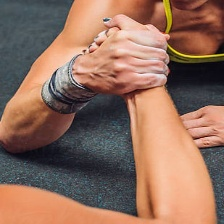

In [4]:
img = tf.keras.preprocessing.image.load_img('/content/sport_archive/train/arm wrestling/08.jpg')
img

# Preprocessing the dataset
1. Loading dataset
2. Convert labels into int number

In [5]:

dataset = {
             "train_data" : "/content/sport_archive/train",
             "valid_data" : "/content/sport_archive/valid",
          }

test_data=  "/content/sport_archive/test"

In [6]:
all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
      folderpath = os.path.join(path, folder)
      if os.path.isdir(folderpath):
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)



    all_data.append(data.copy())
    data.clear()



In [7]:
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])


In [8]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

In [9]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]

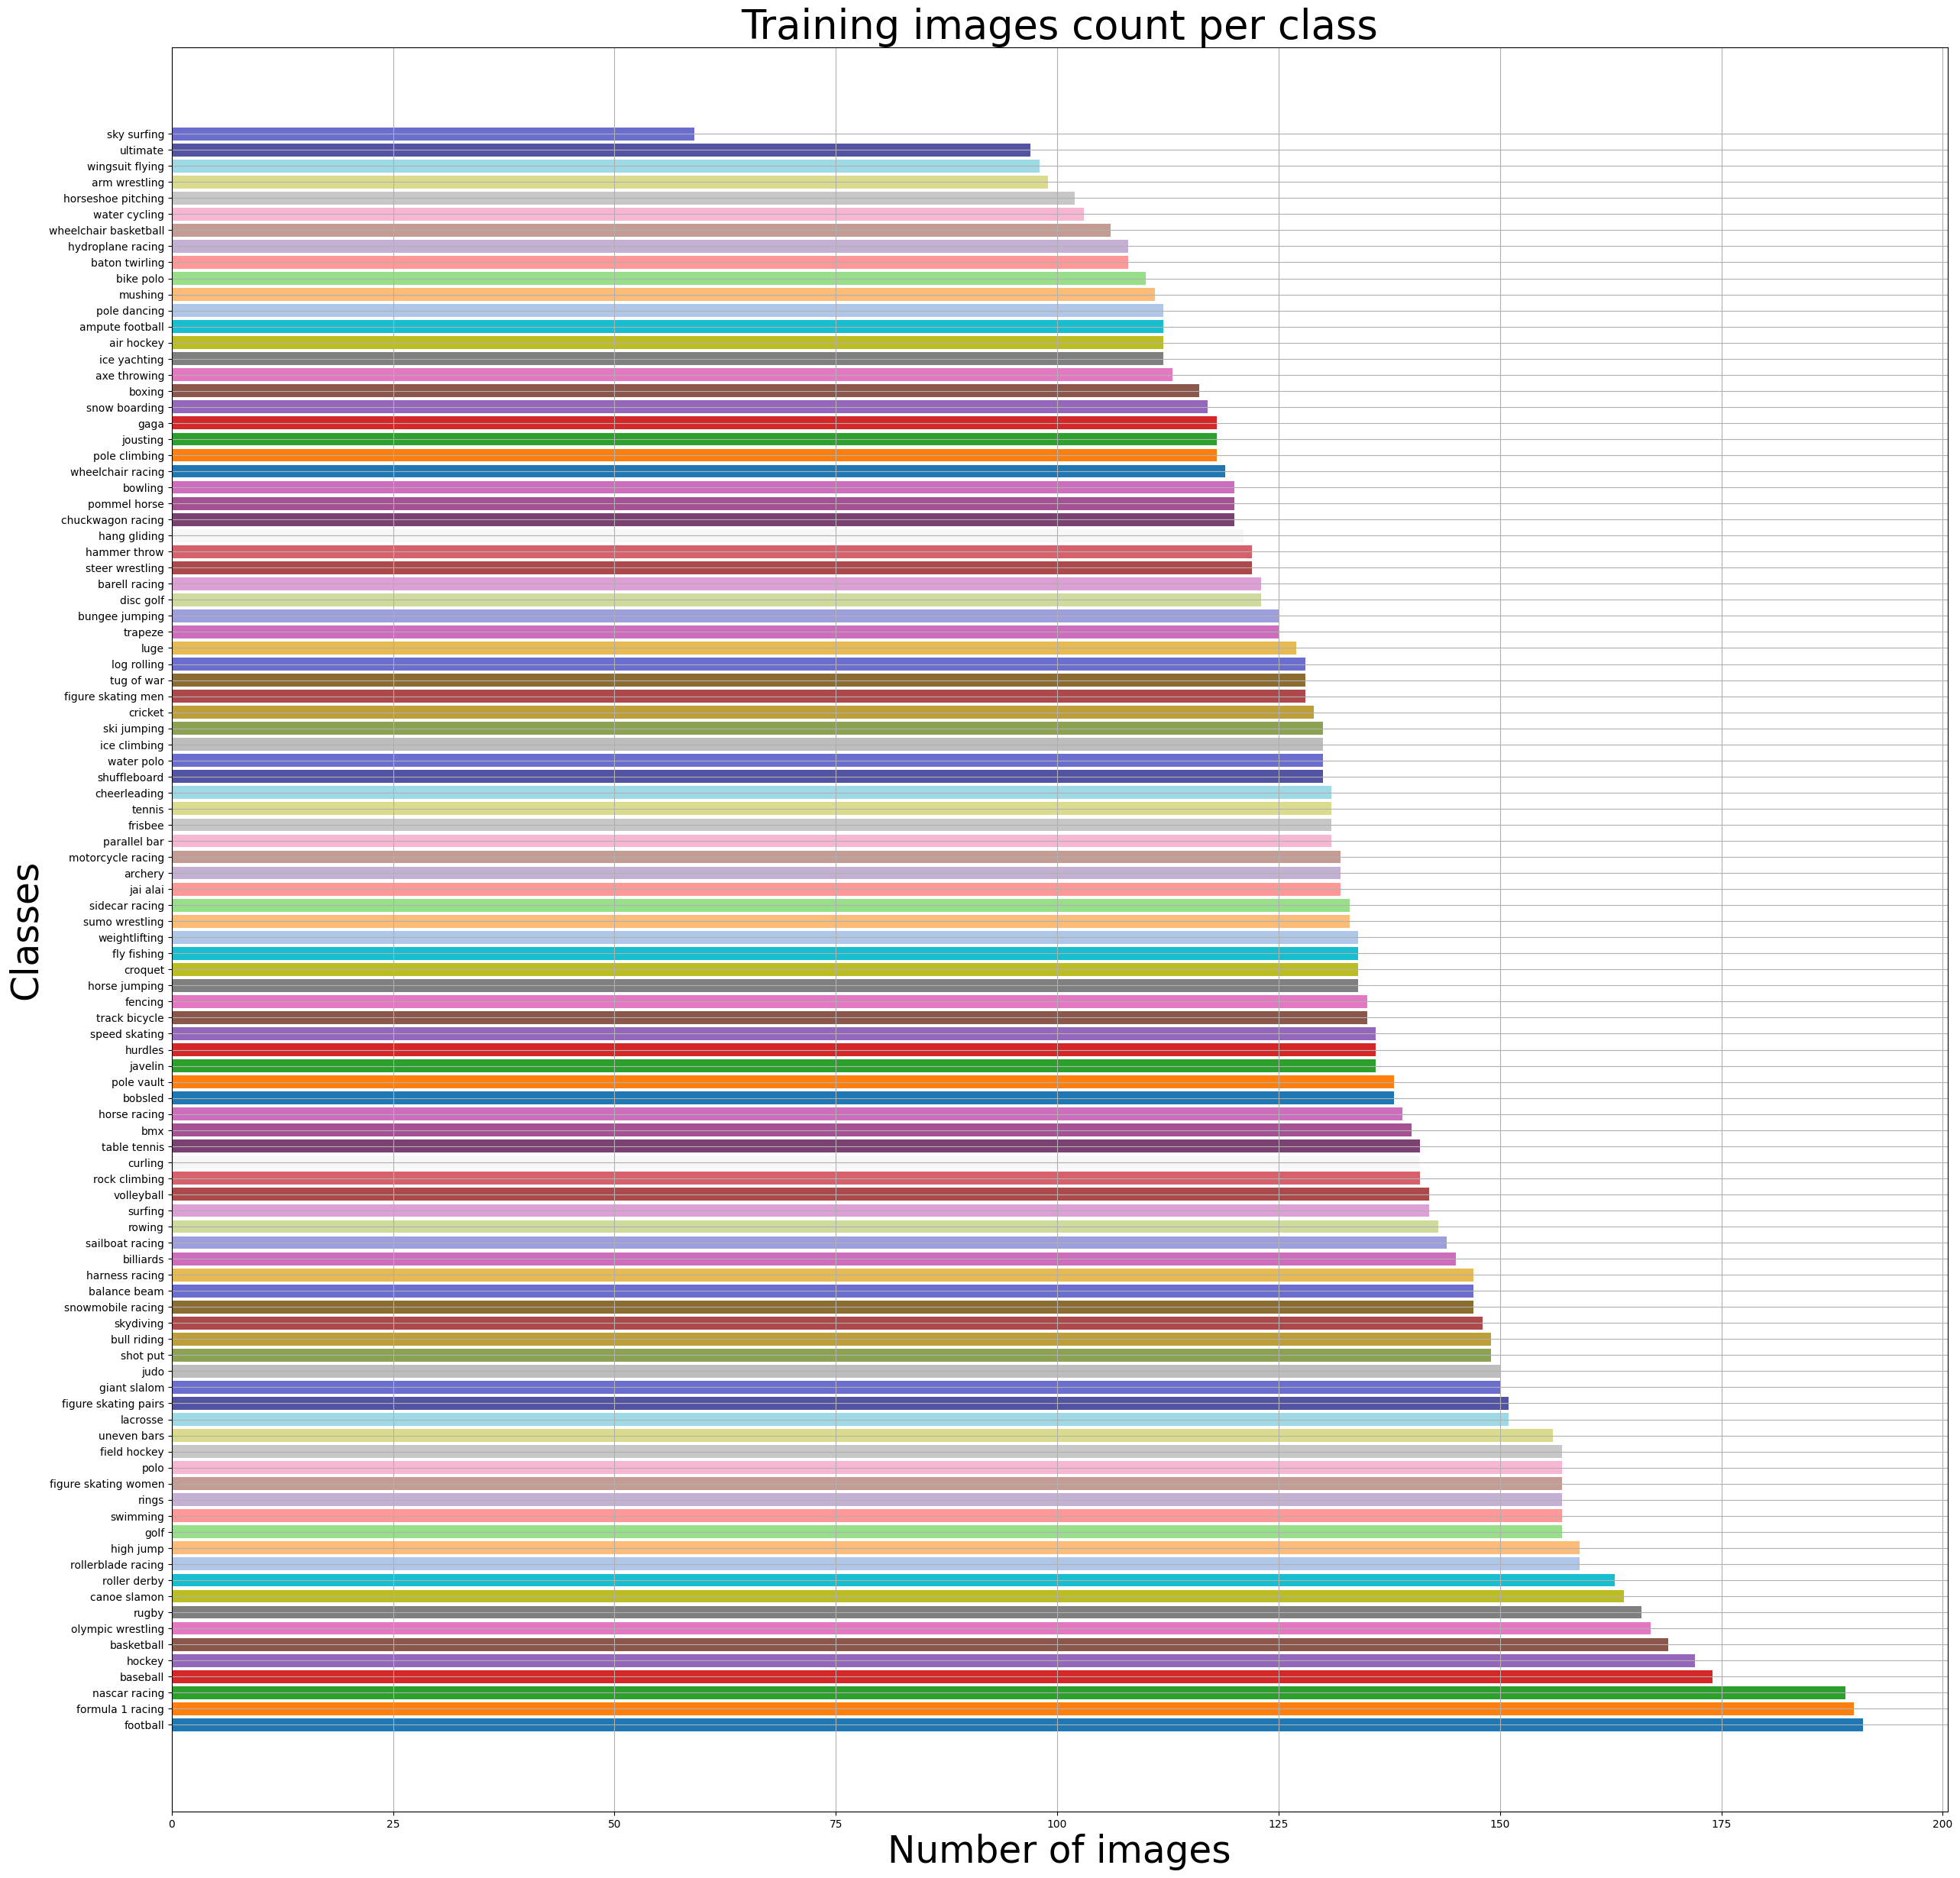

In [10]:
plt.figure(figsize=(30,30))
plt.title("Training images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


In [11]:
train_df.sample(n=10, random_state=1)


imgpath              labels  \
3449   /content/sport_archive/train/speed skating/029...       speed skating   
5802        /content/sport_archive/train/archery/053.jpg             archery   
2979   /content/sport_archive/train/motorcycle racing...   motorcycle racing   
1034   /content/sport_archive/train/rock climbing/114...       rock climbing   
479    /content/sport_archive/train/track bicycle/009...       track bicycle   
9143       /content/sport_archive/train/swimming/110.jpg            swimming   
4737   /content/sport_archive/train/horseshoe pitchin...  horseshoe pitching   
6433           /content/sport_archive/train/golf/015.jpg                golf   
35     /content/sport_archive/train/steer wrestling/0...     steer wrestling   
11522    /content/sport_archive/train/pole vault/065.jpg          pole vault   

       encoded_labels  
3449               81  
5802                2  
2979               56  
1034               67  
479                88  
9143               85  
4737               44  
6433               36  
35                 82  
11522              63

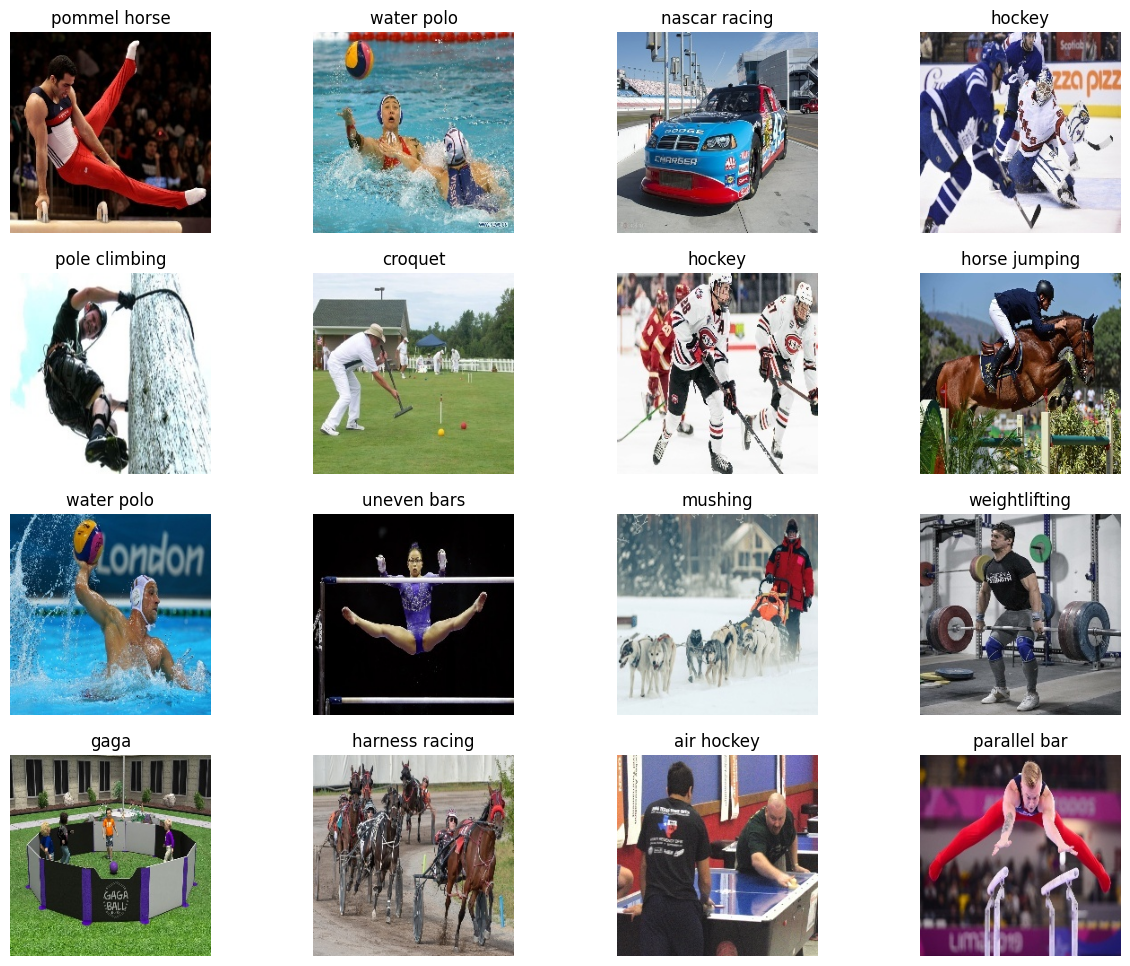

In [12]:
plt.figure(figsize=(10,8))
for i, row in valid_df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('on')
plt.show()

In [13]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)


----------Train-------------
                                             imgpath           labels
0  /content/sport_archive/train/steer wrestling/0...  steer wrestling
1  /content/sport_archive/train/steer wrestling/0...  steer wrestling
2  /content/sport_archive/train/steer wrestling/0...  steer wrestling
3  /content/sport_archive/train/steer wrestling/0...  steer wrestling
4  /content/sport_archive/train/steer wrestling/0...  steer wrestling
(13493, 3)
--------Validation----------
                                             imgpath           labels
0  /content/sport_archive/valid/steer wrestling/5...  steer wrestling
1  /content/sport_archive/valid/steer wrestling/4...  steer wrestling
2  /content/sport_archive/valid/steer wrestling/2...  steer wrestling
3  /content/sport_archive/valid/steer wrestling/1...  steer wrestling
4  /content/sport_archive/valid/steer wrestling/3...  steer wrestling
(500, 3)


In [14]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,)

In [15]:

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="imgpath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

In [16]:
# Freeze pretrained neural network layers

pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [18]:

num_classes = len(set(train_images.classes))



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)

pretrain_out = pretrained_model(x, training = False)

x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.28)(x)


x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

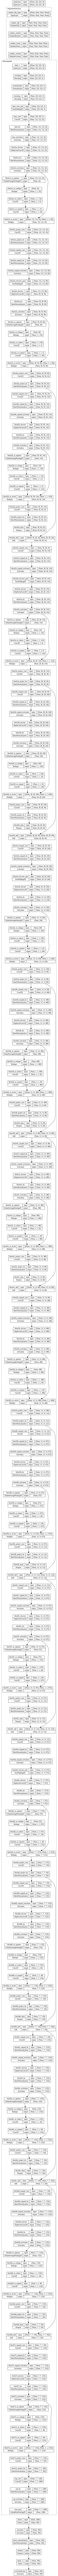

In [31]:
import tensorflow as tf
img_file = 'EfficientNetB0_model.png'

#tf.keras.utils.plot_model(loaded_model, to_file=img_file,expand_nested=True, show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model, to_file=img_file,expand_nested=True, show_shapes=True, show_layer_names=True)

In [20]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)


Epoch 1/50
1350/1350 [==============================] - 66s 35ms/step - loss: 1.7436 - accuracy: 0.5872 - val_loss: 0.5375 - val_accuracy: 0.8400 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 36s 27ms/step - loss: 0.8073 - accuracy: 0.7904 - val_loss: 0.3830 - val_accuracy: 0.8900 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 40s 30ms/step - loss: 0.6420 - accuracy: 0.8280 - val_loss: 0.2881 - val_accuracy: 0.9160 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 36s 27ms/step - loss: 0.5558 - accuracy: 0.8466 - val_loss: 0.2994 - val_accuracy: 0.9140 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 36s 27ms/step - loss: 0.5136 - accuracy: 0.8562 - val_loss: 0.2429 - val_accuracy: 0.9340 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 39s 29ms/step - loss: 0.4838 - accuracy: 0.8650 - val_loss: 0.2804 - val_accuracy: 0.9160 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

In [22]:
model.save_weights('./checkpoints/my_checkpoint')

In [32]:
 # save the trained model as keras HDF5 file format and reload to evaluate
from tensorflow.keras.models import load_model

model.save("v1EfficientNetB0.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


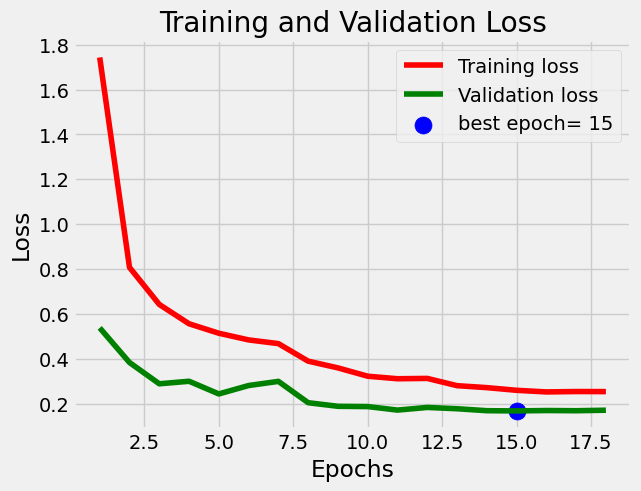

In [36]:
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('EffB0_loss')

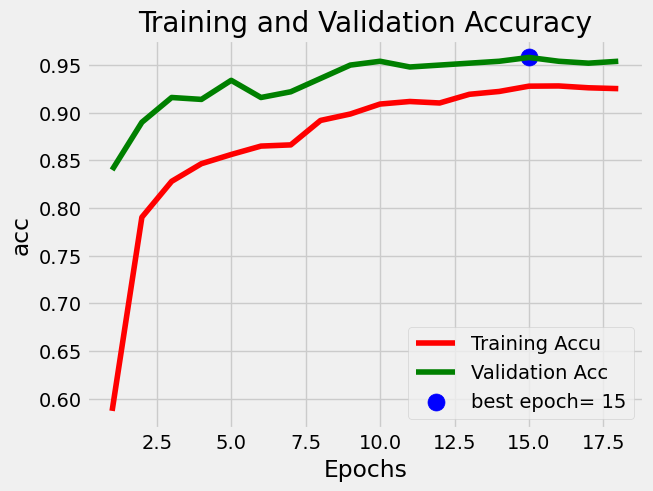

In [37]:
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accu')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Acc')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('EffB0_acc')

# Evaluate test data
https://www.kaggle.com/discussions/general/393359



In [33]:
import glob
import numpy as np
from tensorflow.keras.preprocessing import image

result_df = pd.DataFrame(columns=['ID', 'Category'])

#for img in glob.glob("/content/sport_archive/test/*.jpg"):
for img in glob.glob("/content/sport_archive/test/*"):
  test_img = image.load_img(img,target_size=(224,224))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img,axis=0)
  result = model.predict(test_img)
  result_df = result_df.append({
        'ID':img.split('/')[-1].split('.')[0],
        'Category':np.argmax(result)
    },ignore_index=True)

result_df = result_df.reindex(['ID','Category'], axis=1)
print(result_df)

# save predictions to csv file
result_df.to_csv('team_16_submission.csv', index=False)

1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 29ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 38ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 34ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 38ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 39ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 34ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 45ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 38ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 33ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 28ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 38ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 34ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 34ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 33ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 33ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 41ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 39ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 33ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - ETA: 0s

<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 31ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 27ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 34ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 38ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 40ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 47ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 38ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 41ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 39ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 56ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 41ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 35ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 42ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 36ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 37ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 44ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 23ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 26ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 25ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 28ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 24ms/step


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


1/1 [==============================] - 0s 28ms/step
      ID Category
0    181       82
1    256       63
2    208        9
3    157       71
4    147       70
..   ...      ...
495  280       44
496    8       81
497  292       28
498  317       62
499  247       40

[500 rows x 2 columns]


<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-33-35ecab057045>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


test_loss, test_acc = model.evaluate( test_img, verbose=2)